# Neural Machine Translation for En-Mr

**Install Dependencies**
* `OpenNMT-py`: Open-Source Neural Machine Translation (a framework for NMT)
* `subword-nmt`: Byte pair encoding
* `mosestokenizer`: To tokenize english data
* `indic-nlp`: To normalize and tokenize hindi and marathi data.
* `sacrebleu`: To evaluate performance of NMT systems using BLEU (Bi-lingual Evaluation Understudy) score which is based on n-gram matching

In [ ]:
!pip install subword-nmt
!pip install mosestokenizer
!pip install sacrebleu
!pip install indic-nlp-library
!pip install OpenNMT-py==1.2.0

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

**Create a working directory and change the location**

In [ ]:
cd /content/gdrive/MyDrive/

In [ ]:
mkdir -p NASSCOM_MR

In [ ]:
cd /content/gdrive/MyDrive/NASSCOM_MR/
#Copy trained model and BPE codes here or cd to the directory containing the trained model and bpe codes

**Steps to train and evaluate a Neural Machine Translation (NMT) system**
* Data preprocessing
* Training
* Inference

### Data preparation

**Downloading and Prepare Data** 

For demonstration purpose, we are using a small subset of data

Downloading "PMIndia" Dataset, PMIndia dataset consists of parallel sentences for 13 languages pairs. 

In [ ]:
!wget -c "http://data.statmt.org/pmindia/v1/parallel/pmindia.v1.mr-en.tsv"

**Making separate text files for source and target languages from tsv file**

We do this because OpenNMT works with separate files for source and target languages


In [ ]:
import pandas as pd
tsv_read = pd.read_csv("pmindia.v1.mr-en.tsv", sep='\t',names=["EN", "MR"])
src=tsv_read['EN'].tolist()
tgt=tsv_read['MR'].tolist()

with open('pmi-en.txt', 'w') as f:
    for item in src:
        f.write("%s\n" % item)

with open('pmi-mr.txt', 'w') as f:
    for item in tgt:
        f.write("%s\n" % item)

**Preprocessing Data**
* Normalization
> * Marathi: IndicNLP
* Tokenization
> * English: MosesTokenizer
> * Marathi: IndicNLP
* Byte pair encoding

Byte pair encoding is a subword segmentation algorithm which is used to break the words in it sub-words. The following example illustrates the BPE merge operations:
1. 
```
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
```
2. 
```
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}
```
3. 
```
{'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}
```
This example is taken from [here](https://leimao.github.io/blog/Byte-Pair-Encoding/).


**Create instances of normalizer and tokenizer for english and marathi**

In [ ]:
from mosestokenizer import *
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory

factory = IndicNormalizerFactory()
normalizer = factory.get_normalizer("mr")
tokenize = MosesTokenizer('en')

**Preprocessing functions for** 
> * English: Lowercase + Tokenize
> * Marathi: Normalize + Tokenize


In [ ]:
def preprocess_en(text):
    s = text.lower()
    s = ' '.join(tokenize(s))
    return s

def preprocess_mr(text):
    text = normalizer.normalize(text)
    return ' '.join(indic_tokenize.trivial_tokenize(text))

**Preprocess the Data**

In [ ]:
preprocessed_src = []
preprocessed_tgt = []

for i in src:
    preprocessed_src+=[preprocess_en(i)]
for i in tgt:
    preprocessed_tgt+=[preprocess_mr(i)]

**Extracting Small Sample of Data**

In [ ]:
preprocessed_src_train = [preprocessed_src[i] for i in range(128)]
preprocessed_tgt_train = [preprocessed_tgt[i] for i in range(128)]

#Write preprocessed data back in files (Because OpenNMT deal with files)
with open('train-en.txt', 'w') as f:
    for item in preprocessed_src_train:
        f.write("%s\n" % item)

with open('train-mr.txt', 'w') as f:
    for item in preprocessed_tgt_train:
        f.write("%s\n" % item)

**Learn BPE (Byte Pair Encoding) merges**

Learn BPE merges (Showing here on a small number of sentences with small number of BPE merge operations).

Number of BPE merge operations is an important parameter here.

In [ ]:
!subword-nmt learn-bpe -s 250 < pmi-mr.txt > pmi-bpe-codes-mr.txt
!subword-nmt learn-bpe -s 250 < pmi-en.txt > pmi-bpe-codes-en.txt

**Apply BPE Merges**

We have already stored BPE codes which are trained on complete data (which are being utilized here)

In [ ]:
!subword-nmt apply-bpe -c bpe-codes.mr < train-mr.txt > bpe-train-mr.txt
!subword-nmt apply-bpe -c mr-bpe-codes.en < train-en.txt > bpe-train-en.txt

**Sample Training Data**

Let's look at the dataset before and after preprocessing.

In [ ]:
!head -n 5 train-en.txt

In [ ]:
!head -n 5 bpe-train-en.txt

### Training

The architecture to train an NMT system consists of a stack of encoder layers and a stack of decoder layers, which are fully connected. Each encoder consists of a self-attention component and a feed-forward component. Each decoder consists of three components: self-attention, encoder-decoder attention and a feed-forward layer.
* `Self-attention`: It is a weighted combination of all other token embeddings (including the tokens that appear later in the sentence). While vanilla attention looks at previous hidden states.

* `Positional encoding`: Because self-attention is not able to capture positions, a positional vector is added to the token embeddings prior to feeding it to the self-attention layer.

* `Encoder-decoder attention`: It functions over the output of the decoder's self-attention layer and the output of the last encoder.

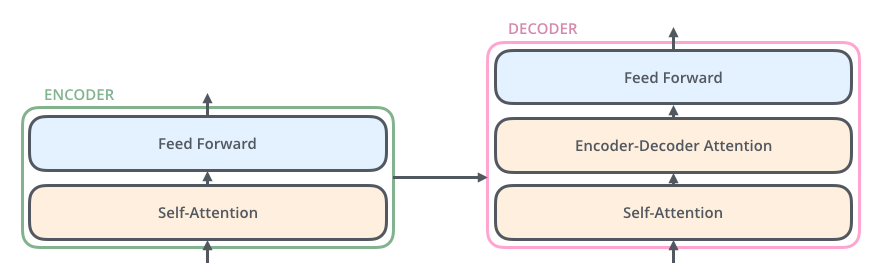


Image source: http://jalammar.github.io/illustrated-transformer/



Train using OpenNMT
*   Build vocabulary and store train data as pytorch tensors
*   Train using OpenNMT
> - `encoder_type`, `decoder_type`: transformer
> - `layers`: Number of  encoder and decoder layers

**Build Vocabulary**

This module create vocabulary based on provided source and target text files and store data in the form of tensors.

In [ ]:
!onmt_preprocess -train_src bpe-train-en.txt -train_tgt bpe-train-mr.txt \
-save_data my_train_data

**Training Model**

Here, we show training on a small sample of data for 20 steps over a trained model (which is trained using various different sources of parallel data). All details of data sources and model is given in the end.

In [ ]:
!onmt_train \
  -data my_train_data \
  -save_model my_model \
  -train_from mr-model.pt \
  -layers 6 -rnn_size 512 -word_vec_size 512 -transformer_ff 2048 \
  -heads 8 -encoder_type transformer -decoder_type transformer -position_encoding \
  -train_steps 200020 -max_generator_batches 2 \
  -dropout 0.1 -batch_size 4 -batch_type tokens \
  -learning_rate 2 \
  -valid_steps 10000 -save_checkpoint_steps 20000 -report_every 1 -world_size 1 -gpu_ranks 0

### Translation

**Load test data and preprocess it**

We are using "test-pmi.en" from WAT 2021 multi-indic-nmt task (Link in references)

In [ ]:
pre_test = []
tokenize = MosesTokenizer('en')
with open('test-pmi.en','r') as f:
    for i in f:
        pre_test = pre_test+[i]

test = []
for i in pre_test:
    test+=[' '.join(tokenize(i.lower()))]

with open('processed-test-pmi.txt','w') as f:
    for item in test:
        f.write("%s\n" % item)
print(len(test))

**Apply BPE, translate using trained model and merge bpe tokens into words.**

The model which is used here, is trained using various datasets.


In [ ]:
%%capture
#Translating Test Data
!subword-nmt apply-bpe -c mr-bpe-codes.en < processed-test-pmi.txt > bpe-processed-test-pmi.txt
!onmt_translate -model mr-model.pt -src bpe-processed-test-pmi.txt -output bpe-trans-pmi.txt -replace_unk -gpu 0
!cat bpe-trans-pmi.txt | sed -E 's/(@@ )|(@@ ?$)//g' > trans-pmi.txt

**Detokenize predicted translations**

In [ ]:
from indicnlp.tokenize import indic_detokenize  
with open('trans-pmi.txt','r') as a,open('detok-trans-pmi.txt','w') as b:
    for item in a:
        b.write("%s" % indic_detokenize.trivial_detokenize(item,lang='mr'))

**Create a function to calculate BLEU score given hypothesis and reference files**

In [ ]:
import sacrebleu

#Function to calculate BLEU score
def score(r,h):
	  ref = []
	  with open(r,'r') as lines:
		    for i in lines:
			      ref.append(i)
	  hypothesis = []
	  with open(h,'r') as lines:
		    for i in lines:
			      hypothesis.append(i)
	  reference=[]
	  reference.append(ref)
	  bleu = sacrebleu.corpus_bleu(hypothesis,reference)
	  return bleu.score

**Calculate BLEU score**

In [ ]:
%%capture
bleu = score("test-pmi.mr","detok-trans-pmi.txt")

In [ ]:
print(bleu)

**Translation/Inference**

In [ ]:
#Function to translate an English sentence
def translate_mr(s):
    s=s.lower()
     #Apply tokenization
    tokenize = MosesTokenizer('en')
    s=' '.join(tokenize(s))
    with open('sentence.txt','w') as f:
        f.write(s)
    #Apply BPE
    !subword-nmt apply-bpe -c mr-bpe-codes.en < sentence.txt > bpe-sentence.txt
    #Translate using OpenNMT
    !onmt_translate -model mr-model.pt -src bpe-sentence.txt -output bpe-trans.txt -replace_unk -gpu 0
    #De-BPE
    !cat bpe-trans.txt | sed -E 's/(@@ )|(@@ ?$)//g' > trans.txt
    out = ""
    with open('trans.txt') as f:
        for i in f:
            out+=i
    return indic_detokenize.trivial_detokenize(out,lang='mr')

In [ ]:
%%capture
def interactive(input_sentence):
  output = translate_mr(input_sentence)
  return output
input_sentence = input("Enter a sentence: ")
output = interactive(input_sentence)

In [ ]:
print(output)

**Details of data and training**

* Training data: It is a combination of 
> * Press Information Bureau
> * PMIndia
> * Bible dataset
> * ILCI: Not publicly available

* Dev and Test data: WAT 2021 multi-indic-nmt task data

All the publicly available data can be downloaded froms: http://lotus.kuee.kyoto-u.ac.jp/WAT/indic-multilingual/)

Model details:
>* Encoder/Decoder type: Transformer
>* Number of layers in Encoder and Decoder: 6 
>* Number of heads in multi-head attention: 8
>* Word Embedding Size: 512
>* Hidden layer dimension in Feed Forward Neural Network: 2048
>* Optimizer: Adam
>* Dropout: 0.1
>* Number of iterations: 200000
>* Other parameters use the default setting in OpenNMT

The training data also includes Back-Translated data generated using the trained system in opposite direction. The monolingal dataset used here is from AI4Bharat dataset (https://github.com/AI4Bharat)

**References**


1. Sennrich, Rico, Barry Haddow, and Alexandra Birch. "Neural Machine Translation of Rare Words with Subword Units." In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pp. 1715-1725. 2016.
2. Klein, Guillaume, Yoon Kim, Yuntian Deng, Jean Senellart, and Alexander M. Rush. "OpenNMT: Open-Source Toolkit for Neural Machine Translation." In Proceedings of ACL 2017, System Demonstrations, pp. 67-72. 2017.
3. Test dataset: (http://lotus.kuee.kyoto-u.ac.jp/WAT/indic-multilingual/)
4. OpenNMT-py: (https://github.com/OpenNMT/OpenNMT-py/)
5. Sacrebleu: (https://github.com/mjpost/sacrebleu)
6. Subword-nmt: (https://github.com/rsennrich/subword-nmt)
7. http://jalammar.github.io/illustrated-transformer/


**Links to various data resources and tools:**

Workshops in Machine Translation
* http://statmt.org/wmt21/
* http://lotus.kuee.kyoto-u.ac.jp/WAT/

Data resources
* https://github.com/AI4Bharat/indicnlp_corpus
* WMT and WAT workshops (mentioned above) provides parallel data for many language pairs

Tools for preprocessing
* https://github.com/anoopkunchukuttan/indic_nlp_library
* https://github.com/moses-smt/mosesdecoder

Frameworks for NMT
* https://huggingface.co/
* https://github.com/pytorch/fairseq